In [1]:
from typing import Callable
from dataclasses import dataclass, fields
from functools import partial
from itertools import cycle
import os
from pathlib import Path
import pdb
import random
import re
import tempfile
from einops import rearrange
import datasets
import numpy as np
import matplotlib.pyplot as plt
import minari
from minigrid.core import constants as mgc
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import pil_to_tensor
from tqdm.notebook import tqdm
from transformers import GPT2Tokenizer, GPT2Config, GPT2Model
random.seed(42)

In [2]:
@dataclass
class ModalityData:
    tokens: torch.Tensor
    targets: torch.Tensor
    attention_mask: torch.Tensor
    embedding: torch.Tensor = torch.tensor([])

    def combine(self, other):
        """Concats attributes of self to attributes of other.

        Example:
        You might have some text that's part of a control task.
        Let's say the text is "reach the exit", the task's goal.
        The control task episode has 4 observations, the previous 4 frames of video.
        Combining the first 3 observations with the last observation would look like:
          The shape of the text tokens of the first 3 observations: (3, 5)
          The shape of the text tokens of the last observation:     (1, 5)
        """
        return type(self)(
            tokens=torch.concat([self.tokens, other.tokens]),
            targets=torch.concat([self.targets, other.targets]),
            attention_mask=torch.concat([self.attention_mask, other.attention_mask]),
            embedding=torch.concat([self.embedding, other.embedding]),
            
        )

    def embed(self, embedder):
        return type(self)(
            tokens=self.tokens,
            targets=self.targets,
            attention_mask=self.attention_mask,
            embedding=self.embed_fn(embedder)(self.tokens),
        ) 

    def to(self, device):
        return type(self)(
            tokens=self.tokens.to(device),
            targets=self.targets.to(device),
            attention_mask=self.attention_mask.to(device),
            embedding=self.embedding.to(device),
        )
        
    @property
    def size(self):
        """The number of tokens this will consume of the context window"""
        return self.tokens.size(0) * self.tokens.size(1)

class TextData(ModalityData):
    def embed_fn(self, embedder):
        return embedder.text

class ImageData(ModalityData):
    def embed_fn(self, embedder):
        return embedder.image
        
class DiscreteData(ModalityData):
    def embed_fn(self, embedder):
        return embedder.discrete

# There is no such thing as ContinuousData.
# Continuous just gets binned to discrete.

In [3]:
# https://docs.python.org/3.7/library/dataclasses.html#dataclasses.dataclass
# The order of the fields of subclasses matters!
@dataclass
class Observation:
    def __getitem__(self, i):
        return type(self)(**{
            field.name: type(getattr(self, field.name))(
                tokens=getattr(self, field.name).tokens[[i]],
                targets=getattr(self, field.name).targets[[i]],
                attention_mask=getattr(self, field.name).attention_mask[[i]],
            )
            for field in fields(self)
        })

    def combine(self, other):
        return type(self)(**{
            field.name: getattr(self, field.name).combine(getattr(other, field.name))
            for field in fields(self)
        })

    @property
    def size(self):
        return sum(getattr(self, field.name).size for field in fields(self))

    @property
    def count(self):
        # This is typically safe. But you might need to override it.
        # For example, the count of a RL observation might be the number
        # of actions, not the number of observations, because the last
        # observation is the "terminated" observation that we don't care about.
        return next(getattr(self, field.name) for field in fields(self)).tokens.size(0)

    def embed(self, embedder):
        return type(self)(**{
            field.name: getattr(self, field.name).embed(embedder)
            for field in fields(self)
        })

    def to(self, device):
        return type(self)(**{
            field.name: getattr(self, field.name).to(device)
            for field in fields(self)
        })

    def sequence(self, sequence_length):
        xs = torch.concat([getattr(self, field.name).embedding for field in fields(self)], dim=1)
        ys = torch.concat([getattr(self, field.name).targets for field in fields(self)], dim=1)
        ms = torch.concat([getattr(self, field.name).attention_mask for field in fields(self)], dim=1)
        T, S, C = xs.shape
        xs, ys, ms = xs.reshape(T*S, C), ys.reshape(T*S), ms.reshape(T*S)
        padding_len = sequence_length - T*S
        xs = F.pad(xs, (0, 0, 0, padding_len), value=0)
        ys, ms = [F.pad(x, (0, padding_len), value=0) for x in [ys, ms]]
        return xs, ys, ms

@dataclass
class GenericTextObservation(Observation):
    text: TextData

@dataclass
class GenericVQAObservation(Observation):
    question: TextData
    image: ImageData
    answer: TextData

# There is no such thing as a GenericRoboticsObservation.
# There's too much variety in robotics datasets.
# But here's an example of what a specific one might look like.
# https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/
@dataclass
class FourRoomsObservation(Observation):
    mission: TextData
    direction: DiscreteData    
    image: ImageData
    action: DiscreteData

    @property
    def count(self):
        return self.action.tokens.size(0)

In [170]:
def images_to_patches(images, patch_size=16):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)

def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

def mu_law_encode(x, M=256, mu=100):
    M = torch.tensor(M, dtype=x.dtype)
    mu = torch.tensor(mu, dtype=x.dtype)
    x_mu = torch.sign(x) * torch.log(torch.abs(x) * mu + 1.0)
    x_mu = x_mu / torch.log(M * mu + 1.0)
    return x_mu

class Tokenizer:
    def __init__(self, text_tokenizer):
        # This is expected to be a partial with reasonable defaults around something like a HuggingFace Tokenizer.
        self.text_tokenizer = text_tokenizer

    @property
    def bos_token(self):
        return self.text_tokenizer.func.bos_token

    @property
    def eos_token(self):
        return self.text_tokenizer.func.eos_token

    # The difference between these two is just the defaults.
    # Generative tokenizer has a ones attention mask.
    # Observative tokenizer has a zeros attention mask.
    def text(self, data, **kwargs):
        tokenized =  self.text_tokenizer(data, **kwargs)
        return TextData(**{
            "tokens": tokenized["input_ids"][:, :-1].to(torch.long),
            "targets": tokenized["input_ids"][:, 1:].to(torch.long),
            "attention_mask": tokenized["attention_mask"][:, :-1],
        })

    def text_obs(self, data, **kwargs):
        text_data = self.text(data)
        text_data.attention_mask = torch.zeros_like(text_data.attention_mask)
        return text_data

    def image(self, data):
        if len(data.shape) == 3:
          data = data.unsqueeze(0)
        patches = images_to_patches(data, patch_size=16)
        # Hardcoding as a reminder to do something smarter
        SQUARE_ROOT_OF_PATCH_SIZE = 3.464
        xs = (
            apply_along_dimension(
                normalize_to_between_minus_one_plus_one, 2, patches
            )
            / SQUARE_ROOT_OF_PATCH_SIZE
        )
        # We don't predict images, but we need ys
        # becaues these image ys will be in our
        # concatenated ys of text/image/action/etc...
        ys = torch.zeros(xs.shape[:2]).to(torch.long)
        ms = torch.zeros(xs.shape[:2])  # Same story as above.
        return ImageData(tokens=xs, targets=ys, attention_mask=ms)

    def discrete_obs(self, data):
        if len(data.shape) == 0:
            data = data.unsqueeze(0)
        if len(data.shape) == 1:
            data = data.unsqueeze(1)
        xs = data[:, :-1] + self.text_tokenizer.func.vocab_size
        ys = data[:, 1:] + self.text_tokenizer.func.vocab_size
        ms = torch.zeros_like(ys)
        return DiscreteData(tokens=xs, targets=ys, attention_mask=ms)

    def discrete_act(self, data):
        discrete_data = self.discrete_obs(data)
        discrete_data.attention_mask = torch.ones_like(discrete_data.targets)
        return discrete_data

    def continuous_obs(self, data):
        if len(data.shape) == 0:
            data = data.unsqueeze(0)
        if len(data.shape) == 1:
            data = data.unsqueeze(1)
        # hardcoding an assumption that boa/eoa surrounds data.
        boa, data, eoa = data[:, [0]], data[:, 1:-1], data[:, [-1]]
        encoded = torch.clip(mu_law_encode(data), -1, 1)
        shifted = (encoded + 1) / 2  # Map [-1, 1] to [0, 1]
        # 1022 because 1023 is boa/eoa
        scaled = (shifted * 1022).long().clamp(0, 1022) + self.text_tokenizer.func.vocab_size
        xs = torch.concat([boa, scaled, eoa], dim=1).to(torch.long)
        ys = xs[:, 1:]
        ms = torch.zeros_like(ys)
        return DiscreteData(tokens=xs, targets=ys, attention_mask=ms)

    def continuous_act(self, data):
        continuous_data = self.continuous_obs(data)
        continuous_data.attention_mask = torch.ones_like(continuous_data.targets)
        return continuous_data

In [171]:
tokenizer = Tokenizer(_text_tokenizer)

In [172]:
torch.tensor([1023, 0.1,  1023])

tensor([1.0230e+03, 1.0000e-01, 1.0230e+03])

In [173]:
tokenizer.continuous_obs(torch.tensor([[1023, 0.1, -0.9, 0.77, 1023]]))

DiscreteData(tokens=tensor([[ 1023, 50888, 50540, 50987,  1023]]), targets=tensor([[50888, 50540, 50987,  1023]]), attention_mask=tensor([[0, 0, 0, 0]]), embedding=tensor([]))

In [174]:
tokenizer.continuous_act(torch.tensor([[1023, 0.1, -0.9, 0.77, 1023]]))

DiscreteData(tokens=tensor([[ 1023, 50888, 50540, 50987,  1023]]), targets=tensor([[50888, 50540, 50987,  1023]]), attention_mask=tensor([[1, 1, 1, 1]]), embedding=tensor([]))

In [5]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.transform(self.dataset[idx])

In [6]:
# Some FourRooms/Minigrid-specific stuff to turn
# a 7x7x3 non-pixel observation into an pixel/image observation.
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in mgc.IDX_TO_COLOR.items():
    lut[idx] = mgc.COLORS[color_name]

def minigrid_to_rgb(episode):
    """Convert discrete "image" observations into actual images.
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    image = lut[episode.observations['image'][:, :, :, 1]]
    # Convert to PyTorch tensor and permute
    image = torch.from_numpy(image).permute(0, 3, 1, 2)
    return image

In [7]:
image_transform = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),    
    transforms.RandomResizedCrop((192, 192), (0.6, 1.0)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
def four_rooms_tokenizer(tokenizer, episode, boa_token_id=1023, eoa_token_id=1023):
    # There is always 1 more observation than there are actions,
    # the "terminated" observation, which we don't care about.
    # So take up to the :-1 of everything other than the actions.
    image = image_transform(minigrid_to_rgb(episode)[:-1])
    image = tokenizer.image(image)
    mission = tokenizer.text_obs(episode.observations['mission'][:-1], padding=False)
    direction = tokenizer.discrete_obs(torch.from_numpy(episode.observations['direction'])[:-1])
    action = tokenizer.discrete_act(torch.stack(
        [torch.stack([torch.tensor(boa_token_id), action, torch.tensor(eoa_token_id)]) 
        for action in torch.from_numpy(episode.actions)]
    ))
    return FourRoomsObservation(mission=mission, image=image, direction=direction, action=action)
    
def vqa_tokenizer(tokenizer, sample):
    image = tokenizer.image(image_transform(pil_to_tensor(sample["image"])))
    answer = tokenizer.text(random.choice(sample["answers"])["answer"], padding=False)
    question = tokenizer.text_obs(sample["question"])
    all_observations = GenericVQAObservation(question=question, image=image, answer=answer)
    i = random.randint(0, all_observations.count - 1)
    observation = all_observations[i]
    i += 1
    while i < all_observations.count and observation.size + observation[0].size < SEQUENCE_LENGTH:
        observation = observation.combine(all_observations[i])
        i += 1
    return observation

In [9]:
def minigrid_collate_fn(batch):
    """TODO: This isn't collation."""
    result = []
    for sample in batch:
        i = random.randint(0, sample.count - 1)
        # Starting at that index, we'll continue adding observations to our context window until
        # we run out of space.
        step = sample[i]
        i += 1
        while i < sample.count and step.size + step[0].size < SEQUENCE_LENGTH:
            step = step.combine(sample[i])
            i += 1
        result.append(step)
    return result

In [10]:
def text_tokenizer(tokenizer, text, bos_token='<|endoftext|>', eos_token='<|endoftext|>'):
    return GenericTextObservation(text=tokenizer.text(bos_token + text + eos_token))

# Datasets

In [11]:
def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [12]:
minigrid_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")
shakespeare_dataset = acquire_shakespeare_dataset()

## Transform and Tokenize

In [13]:
SEQUENCE_LENGTH = 1024

In [14]:
__text_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2", clean_up_tokenization_spaces=True)
__text_tokenizer.pad_token = __text_tokenizer.eos_token
_text_tokenizer = partial(
    __text_tokenizer,
    max_length=SEQUENCE_LENGTH,
    truncation=True,
    return_tensors="pt",
)

In [15]:
tokenizer = Tokenizer(_text_tokenizer)
four_rooms_tokenize = partial(four_rooms_tokenizer, tokenizer)
vqa_tokenize = partial(vqa_tokenizer, tokenizer)

In [16]:
text_tokenize = partial(text_tokenizer, tokenizer)

In [17]:
batch = [text_tokenize(x) for x in shakespeare_dataset[:3]]
print(batch[0].text.tokens.shape)
batch = minigrid_collate_fn(four_rooms_tokenize(minigrid_dataset[i]) for i in range(3))
print(batch[0].action.tokens.shape, batch[0].image.tokens.shape, batch[0].image.attention_mask.shape)

torch.Size([1, 453])
torch.Size([6, 2]) torch.Size([6, 144, 768]) torch.Size([6, 144])


In [18]:
text_tokenize('hello, world')

GenericTextObservation(text=TextData(tokens=tensor([[50256, 31373,    11,   995]]), targets=tensor([[31373,    11,   995, 50256]]), attention_mask=tensor([[1, 1, 1, 1]]), embedding=tensor([])))

## Transform

In [19]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, text_tokenize)
minigrid_dataset_xf = TransformDataset(minigrid_dataset, four_rooms_tokenize)
vqa_dataset_xf = TransformDataset(vqa_dataset['train'], vqa_tokenize)

## DataLoader

In [20]:
BATCH_SIZE=3

In [21]:
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x)
shakespeare_batch = next(iter(shakespeare_dataloader))
shakespeare_batch[0].text.tokens.shape

torch.Size([1, 453])

In [22]:
minigrid_dataloader = DataLoader(minigrid_dataset_xf, batch_size=BATCH_SIZE, collate_fn=minigrid_collate_fn)
minigrid_batch = next(iter(minigrid_dataloader))
len(minigrid_batch), minigrid_batch[0].mission.tokens.shape, minigrid_batch[0].image.tokens.shape

(3, torch.Size([6, 2]), torch.Size([6, 144, 768]))

In [23]:
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x)
vqa_batch = next(iter(vqa_dataloader))
vqa_batch[0].question.tokens.shape, vqa_batch[0].image.tokens.shape, vqa_batch[0].answer.targets.shape

(torch.Size([1, 9]), torch.Size([1, 144, 768]), torch.Size([1, 2]))

# Embed

In [24]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

In [25]:
@dataclass
class Embedder:
    discrete_embedding: Callable
    image_embedding: Callable

    def text(self, data):
        return self.discrete_embedding(data)

    def discrete(self, data):
        return self.discrete_embedding(data)

    def image(self, data):
        return self.image_embedding(data)

@dataclass
class MiniGatoConfig:
    embedding_dim: int
    sequence_length: int
    vocab_size: int 
    transformer_config: GPT2Config
    transformer: GPT2Model

def init_default_config() -> MiniGatoConfig:
    transformer_config = GPT2Config()
    return MiniGatoConfig(
        embedding_dim=768,
        sequence_length=1024,
        vocab_size=__text_tokenizer.vocab_size,
        transformer_config=transformer_config,
        transformer=GPT2Model(transformer_config),
    )

default_config = init_default_config()

class MiniGato(nn.Module):
    def __init__(self, config: MiniGatoConfig=default_config):
        super().__init__()
        self.config = config
        self.sequence_length = self.config.sequence_length
        # text + discrete + continuous (text and continuous _are_ discrete when you think about it)
        discrete_embedding = nn.Embedding(self.config.vocab_size + 1024, self.config.embedding_dim)
        image_embedding = ResNetV2Block(3, self.config.embedding_dim)
        self.embedder = Embedder(discrete_embedding=discrete_embedding, image_embedding=image_embedding)
        self.transformer = self.config.transformer
        self.lm_head = nn.Linear(self.transformer.config.hidden_size, self.config.vocab_size + 1024)     

    def forward(self, batch):
        batch = [
            sample.embed(self.embedder).sequence(self.sequence_length) for sample in batch
        ]
        xs, ys, ms = map(torch.stack, zip(*batch))
        xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
        out = self.transformer(inputs_embeds=xs)
        predicted = self.lm_head(out.last_hidden_state)
        return predicted, ys, ms

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
minigrid_iterator = iter(minigrid_dataloader)

In [28]:
minigrid_batch = next(minigrid_iterator)

In [29]:
def infinite_dataloader(fn):
    it = iter(fn())
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(fn())

In [30]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1).to(torch.long)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / (mask.sum() + 1e-8)
    return loss

In [31]:
class MiniGatoTrainer:
    def __init__(self, model, optimizer, dataloaders, scheduler=None, lr=3e-4, num_iterations=10):
        self.model = model
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.scheduler = scheduler
        self.dl_it = cycle(dataloaders)
        self.losses = []
        self.num_iterations = num_iterations
        self.lr = lr

    def train(self):
        self.model.train()
        for i in tqdm(range(self.num_iterations)):
            dl = next(self.dl_it)
            batch = next(dl)
            optimizer.zero_grad()
            predicted, targets, attention_mask = self.model(batch)
            loss = cross_entropy(predicted, targets, attention_mask)
            self.losses.append(loss.item())
            loss.backward()
            if self.scheduler:
                self.scheduler.step()
            self.optimizer.step()

In [32]:
BATCH_SIZE=3

In [33]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, minigrid_dataset_xf, batch_size=BATCH_SIZE, collate_fn=minigrid_collate_fn)),
    infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x)),
]
dl_it = cycle(dataloaders)

In [34]:
config = init_default_config()
model = MiniGato(config).to(device)

# Pre-training

In [35]:
__text_tokenizer.bos_token

'<|endoftext|>'

In [36]:
text = ""
text_observation = text_tokenize("")
text_observation

GenericTextObservation(text=TextData(tokens=tensor([[50256]]), targets=tensor([[50256]]), attention_mask=tensor([[1]]), embedding=tensor([])))

In [37]:
text_embedding = text_observation.embed(model.embedder)
text_embedding.text.embedding.shape

torch.Size([1, 1, 768])

In [38]:
text_sequence_tokens, text_sequence_targets, text_sequence_attention_mask = text_embedding.sequence(model.sequence_length)
text_sequence_tokens.shape, text_sequence_targets.shape, text_sequence_attention_mask.sum()

(torch.Size([1024, 768]), torch.Size([1024]), tensor(1))

In [39]:
batch = [text_observation]
predicted, targets, attention_mask = model(batch)
predicted.shape

torch.Size([1, 1024, 51281])

In [40]:
predicted[0, text_observation.size].topk(k=10)

torch.return_types.topk(
values=tensor([2.1912, 2.1856, 2.1356, 2.1326, 2.1207, 2.1041, 2.0973, 2.0407, 2.0375,
        2.0003], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([ 6024, 26424, 44641, 37458, 21052, 11452, 42792, 51202,  3718, 44096],
       device='cuda:0'))

In [43]:
topk.indices.flatten()

tensor([ 6024, 26424, 44641, 37458, 21052, 11452, 42792, 51202,  3718, 44096],
       device='cuda:0')

In [49]:
topk = (predicted.exp() / predicted.exp().sum(dim=2, keepdims=True))[:, [text_observation.size]].topk(k=10, dim=2)
print(f"Top predicted tokens: {', '.join(__text_tokenizer.decode([x]) if x < __text_tokenizer.vocab_size else f"<{str(x.item())}>" for x in topk.indices.flatten())}")
print(f"Token probabilities: {', '.join([f'{x:.4f}' for x in topk.values.flatten().tolist()])}")

Top predicted tokens: pg,  ransom,  Gest,  missionaries, olean,  subscrib,  Kejriwal, <51202>,  prec,  forging
Token probabilities: 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001


In [50]:
sample = minigrid_dataset[0]
sample

EpisodeData(id=0, total_steps=19, observations={direction: ndarray of shape (20,) and dtype int64, image: ndarray of shape (20, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (19,) and dtype int64, rewards=ndarray of 19 floats, terminations=ndarray of 19 bools, truncations=ndarray of 19 bools, infos=dict with the following keys: [])

In [51]:
# Let's predict the action after the first 4 observations.
fourrooms_observation = four_rooms_tokenize(sample)[:4]
fourrooms_observation.action

DiscreteData(tokens=tensor([[51280, 50258],
        [51280, 50258],
        [51280, 50259],
        [51280, 50259]]), targets=tensor([[50258, 51280],
        [50258, 51280],
        [50259, 51280],
        [50259, 51280]]), attention_mask=tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1]]), embedding=tensor([]))

In [52]:
fourrooms_observation.mission.tokens.shape

torch.Size([4, 2])

In [53]:
fourrooms_embedding = fourrooms_observation.embed(model.embedder)
fourrooms_embedding.action.embedding.shape

torch.Size([4, 2, 768])

In [54]:
fourrooms_sequence_tokens, fourrooms_sequence_targets, fourrooms_sequence_attention_mask = fourrooms_embedding.sequence(model.sequence_length)
fourrooms_sequence_tokens.shape

torch.Size([1024, 768])

In [55]:
batch = [fourrooms_observation]
predicted, targets, attention_mask = model(batch)
predicted.shape

torch.Size([1, 1024, 51281])

In [56]:
# What's the index of the 4th action that we're trying to predict?
fourrooms_observation.size, fourrooms_observation.action.tokens.size(1)

(592, 2)

In [57]:
# The first token is the "beginning of action" token – a separator between the observations and actions.
i = fourrooms_observation.size - fourrooms_observation.action.tokens.size(1)
(model.embedder.discrete_embedding.weight.data @ fourrooms_sequence_tokens[i]).argmax()

tensor(51280)

In [58]:
# The next token is the first one we want to predict.
(model.embedder.discrete_embedding.weight.data @ fourrooms_sequence_tokens[i+1]).argmax()

tensor(50259)

In [59]:
batch = [fourrooms_observation]
predicted, targets, attention_mask = model(batch)
predicted.shape

torch.Size([1, 1024, 51281])

In [60]:
topk = (predicted.exp() / predicted.exp().sum(dim=2, keepdims=True))[:, [i]].topk(k=10, dim=2)
print(f"Top predicted tokens: {', '.join(f'{x}' for x in topk.indices.flatten())}")
print(f"Token probabilities: {', '.join([f'{x:.4f}' for x in topk.values.flatten().tolist()])}")

Top predicted tokens: 3529, 45120, 25867, 47761, 39374, 1409, 48240, 13569, 35364, 35194
Token probabilities: 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001


# Training

In [61]:
NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-5)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=LR,
)

In [62]:
trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
# config = init_default_config()
# model = MiniGato(config).to(device)

In [64]:
trainer.losses[-10:]

[0.5259374976158142,
 6.405041694641113,
 11.026030540466309,
 0.5350190997123718,
 6.358339309692383,
 10.397801399230957,
 0.7153856754302979,
 6.281988143920898,
 9.334275245666504,
 0.6752843856811523]

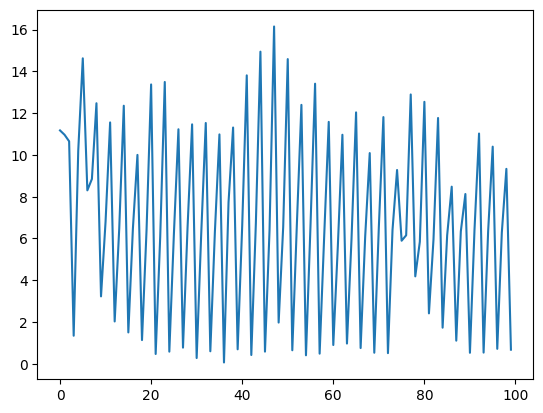

In [65]:
plt.plot(trainer.losses)

In [66]:
window_size = 10
data = torch.tensor(trainer.losses)
moving_avg = torch.conv1d(
    data.view(1, 1, data.size(0)), 
    torch.ones(1, 1, window_size) / window_size,
).squeeze()

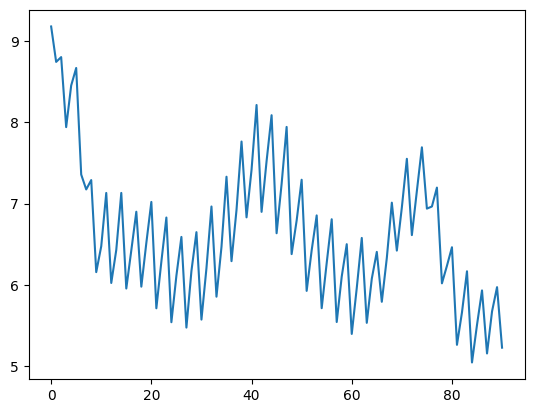

In [67]:
plt.plot(moving_avg)

# Post-Training

In [68]:
sample = minigrid_dataset[0]
sample

EpisodeData(id=0, total_steps=19, observations={direction: ndarray of shape (20,) and dtype int64, image: ndarray of shape (20, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (19,) and dtype int64, rewards=ndarray of 19 floats, terminations=ndarray of 19 bools, truncations=ndarray of 19 bools, infos=dict with the following keys: [])

In [69]:
# Let's predict the action after the first 4 observations.
fourrooms_observation = four_rooms_tokenize(sample)[:4]
fourrooms_observation.action

DiscreteData(tokens=tensor([[51280, 50258],
        [51280, 50258],
        [51280, 50259],
        [51280, 50259]]), targets=tensor([[50258, 51280],
        [50258, 51280],
        [50259, 51280],
        [50259, 51280]]), attention_mask=tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1]]), embedding=tensor([]))

In [70]:
fourrooms_observation.mission.tokens.shape

torch.Size([4, 2])

In [71]:
fourrooms_embedding = fourrooms_observation.embed(model.embedder)
fourrooms_embedding.action.embedding.shape

torch.Size([4, 2, 768])

In [72]:
fourrooms_sequence_tokens, fourrooms_sequence_targets, fourrooms_sequence_attention_mask = fourrooms_embedding.sequence(model.sequence_length)
fourrooms_sequence_tokens.shape

torch.Size([1024, 768])

In [73]:
batch = [fourrooms_observation]
predicted, targets, attention_mask = model(batch)
predicted.shape

torch.Size([1, 1024, 51281])

In [74]:
# What's the index of the 4th action that we're trying to predict?
fourrooms_observation.size, fourrooms_observation.action.tokens.size(1)

(592, 2)

In [75]:
# The first token is the "beginning of action" token – a separator between the observations and actions.
i = fourrooms_observation.size - fourrooms_observation.action.tokens.size(1)
(model.embedder.discrete_embedding.weight.data @ fourrooms_sequence_tokens[i]).argmax()

tensor(51280)

In [76]:
# The next token is the first one we want to predict.
(model.embedder.discrete_embedding.weight.data @ fourrooms_sequence_tokens[i+1]).argmax()

tensor(50259)

In [77]:
batch = [fourrooms_observation]
predicted, targets, attention_mask = model(batch)
predicted.shape

torch.Size([1, 1024, 51281])

In [78]:
topk = (predicted.exp() / predicted.exp().sum(dim=2, keepdims=True))[:, [i]].topk(k=10, dim=2)
print(f"Top predicted tokens: {', '.join(f'{x}' for x in topk.indices.flatten())}")
print(f"Token probabilities: {', '.join([f'{x:.4f}' for x in topk.values.flatten().tolist()])}")

Top predicted tokens: 50259, 50257, 50258, 454, 514, 198, 374, 593, 730, 661
Token probabilities: 0.9364, 0.0477, 0.0052, 0.0010, 0.0008, 0.0008, 0.0006, 0.0003, 0.0003, 0.0003


In [86]:
# It _should_ be predicting 1, but it's predicting 2 (50259 - 50257).
# 2 is such a common action that it can get a low loss by just predicting 2 for everything.
# I would expect with more training, the probability for 1 will go up, 
# even if the `topk` still predicts 2 for a long time to come.
[minigrid_dataset[i].actions for i in range(5)]

[array([1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2]),
 array([1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 2]),
 array([0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2]),
 array([1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])]

In [79]:
sample = minigrid_dataset[100]
fourrooms_observation = four_rooms_tokenize(sample)[:4]
batch = [fourrooms_observation]
predicted, targets, attention_mask = model(batch)
topk = (predicted.exp() / predicted.exp().sum(dim=2, keepdims=True))[:, [i]].topk(k=10, dim=2)
print(f"Target token: {fourrooms_observation.action.tokens}")
print(f"Top predicted tokens: {', '.join(f'{x}' for x in topk.indices.flatten())}")
print(f"Token probabilities: {', '.join([f'{x:.4f}' for x in topk.values.flatten().tolist()])}")

Target token: tensor([[51280, 50259],
        [51280, 50259],
        [51280, 50259],
        [51280, 50257]])
Top predicted tokens: 50259, 50257, 50258, 198, 454, 514, 374, 593, 661, 730
Token probabilities: 0.9358, 0.0451, 0.0065, 0.0010, 0.0010, 0.0008, 0.0007, 0.0004, 0.0003, 0.0003


```
Target token: tensor([[51280, 50259],
        [51280, 50259],
        [51280, 50259],
        [51280, 50257]])
Top predicted tokens: 50259, 50257, 50258, 44558, 42175, 53, 2879, 3539, 321, 45
Token probabilities: 0.8277, 0.0258, 0.0069, 0.0056, 0.0041, 0.0037, 0.0032, 0.0022, 0.0020, 0.0019
```

If you run a few more training iterations, you should see 0.0258 go up.

# More Datasets

In [95]:
# minigrid_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
# vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")
# shakespeare_dataset = acquire_shakespeare_dataset()
pointmaze_dataset = minari.load_dataset('D4RL/pointmaze/open-v2', download=True)

In [96]:
def pointmaze_tokenizer(tokenizer, episode, boa_token_id=1023, eoa_token_id=1023):
    # There is always 1 more observation than there are actions,
    # the "terminated" observation, which we don't care about.
    # So take up to the :-1 of everything other than the actions.
    image = image_transform(minigrid_to_rgb(episode)[:-1])
    image = tokenizer.image(image)
    mission = tokenizer.text_obs(episode.observations['mission'][:-1], padding=False)
    direction = tokenizer.discrete_obs(torch.from_numpy(episode.observations['direction'])[:-1])
    action = tokenizer.discrete_act(torch.stack(
        [torch.stack([torch.tensor(boa_token_id), action, torch.tensor(eoa_token_id)]) 
        for action in torch.from_numpy(episode.actions)]
    ))
    return FourRoomsObservation(mission=mission, image=image, direction=direction, action=action)

In [97]:
pointmaze_dataset[0].observations["observation"][:3]

array([[-2.15781409, -1.16204705,  0.        ,  0.        ],
       [-2.15543246, -1.15966541,  0.23816384,  0.23816384],
       [-2.15067485, -1.15490781,  0.47576046,  0.47576046]])

In [98]:
pointmaze_dataset[0]

EpisodeData(id=0, total_steps=45, observations={achieved_goal: ndarray of shape (46, 2) and dtype float64, desired_goal: ndarray of shape (46, 2) and dtype float64, observation: ndarray of shape (46, 4) and dtype float64}, actions=ndarray of shape (45, 2) and dtype float32, rewards=ndarray of 45 floats, terminations=ndarray of 45 bools, truncations=ndarray of 45 bools, infos=dict with the following keys: ['goal', 'qpos', 'qvel', 'success'])

In [104]:
pointmaze_dataset[0].observations['achieved_goal'][:3]

array([[-2.15781409, -1.16204705],
       [-2.15543246, -1.15966541],
       [-2.15067485, -1.15490781]])

In [105]:
pointmaze_dataset[0].observations['desired_goal'][:3]

array([[-2.22308949,  0.86017994],
       [-2.22308949,  0.86017994],
       [-2.22308949,  0.86017994]])

In [92]:
vqa_batch = next(iter(DataLoader(vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=lambda x: x, num_workers=4)))

In [93]:
emb = vqa_batch[0].embed(model.embedder)
emb.question.embedding.shape, emb.image.embedding.shape, emb.answer.embedding.shape
cc = torch.concat([emb.question.embedding, emb.image.embedding, emb.answer.embedding], dim=1)
F.pad(cc, (0, 0, 0, 1024 - cc.size(1)), value=0).shape

torch.Size([1, 1024, 768])

In [94]:
vqa_batch[0].embed(model.embedder).sequence(1024)[0].shape, vqa_batch[0].embed(model.embedder).sequence(1024)[1].shape

(torch.Size([1024, 768]), torch.Size([1024]))

In [80]:
dl = iter(minigrid_dataloader)

In [81]:
batch = next(dl)

In [82]:
ep = batch
em = [e.embed(model.embedder) for e in ep]
sq = [e.sequence(model.sequence_length) for e in em]
xs, ys, ms = map(torch.stack, zip(*sq))
pr, ys, ms = model(ep)

In [83]:
ep[0].action

DiscreteData(tokens=tensor([[51280, 50259],
        [51280, 50258],
        [51280, 50259],
        [51280, 50259],
        [51280, 50259],
        [51280, 50259]]), targets=tensor([[50259, 51280],
        [50258, 51280],
        [50259, 51280],
        [50259, 51280],
        [50259, 51280],
        [50259, 51280]]), attention_mask=tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]]), embedding=tensor([]))

In [116]:
ep[0].size, ep[0].size // ep[0][0].size, ep[-1].action.targets, pr.shape, ys.shape

(882,
 6,
 tensor([], size=(6, 0), dtype=torch.int64),
 torch.Size([4, 1024, 50257]),
 torch.Size([4, 1024]))

In [117]:
heat = 0.01
prh = pr / heat
sm = prh.softmax(dim=2)

In [100]:
sm.shape

torch.Size([4, 1024, 50257])

Which indexes do you want? Not the 1023, because of padding.

In [101]:
pr.shape, ms.shape, ms[0].nonzero().shape, ms[0].nonzero()

(torch.Size([4, 1024, 50257]),
 torch.Size([4, 1024]),
 torch.Size([0, 1]),
 tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64))

In [102]:
[ys[batch_index][ms[batch_index].nonzero().flatten()].to(torch.int) for batch_index in range(len(batch))]

[tensor([], device='cuda:0', dtype=torch.int32),
 tensor([], device='cuda:0', dtype=torch.int32),
 tensor([], device='cuda:0', dtype=torch.int32),
 tensor([], device='cuda:0', dtype=torch.int32)]

In [103]:
[pr[batch_index][ms[batch_index].nonzero().flatten()].argmax(dim=1).to(torch.int) for batch_index in range(len(batch))]

[tensor([], device='cuda:0', dtype=torch.int32),
 tensor([], device='cuda:0', dtype=torch.int32),
 tensor([], device='cuda:0', dtype=torch.int32),
 tensor([], device='cuda:0', dtype=torch.int32)]

In [104]:
ms[0].nonzero().flatten().tolist(), pr[0][0, [1, 2, 1023]]

([],
 tensor([-9.6881, -8.5413, -9.0677], device='cuda:0', grad_fn=<IndexBackward0>))

In [105]:
sl = torch.multinomial(sm[:, 893, :], num_samples=1)
sl

tensor([[4399],
        [4399],
        [ 504],
        [ 377]], device='cuda:0')

In [109]:
def eval_text():
    model.eval()
    text = "First Citizen:"
    next_word_token = None
    i = 0
    while i < 20 and next_word_token != __text_tokenizer.eos_token:
        with torch.no_grad():
            tokens = text_tokenize(text)
            x = tokens.embed(model.embedder).to(device)
            pr, ys, ms = model([tokens])
            heat = 0.5
            prh = pr / heat
            sm = prh.softmax(dim=2)
            last_index = ms.nonzero()[-1].cpu()[1]
            next_word_probs = sm[0, last_index-1]
            next_word_token = torch.multinomial(next_word_probs, num_samples=1)
            next_word = __text_tokenizer.decode(next_word_token)
            text += next_word
        i += 1
    return text

In [111]:
print(eval_text())

First Citizen: were
:


,I
USI:US
:Now Cor, you



In [112]:
targets = [ys[batch_index][ms[batch_index].nonzero().flatten()].to(torch.int) for batch_index in range(len(batch))][0]
predicted = [pr[batch_index][ms[batch_index].nonzero().flatten()].argmax(dim=1).to(torch.int) for batch_index in range(len(batch))][0]
print(f"Control targets:   {targets.tolist()}\nControl predicted: {predicted.tolist()}")

Control targets:   []
Control predicted: []


In [89]:
sm[0].shape[

torch.Size([1024, 50257])

In [117]:
vqa_sample = next(iter(vqa_dataset["train"]))

In [118]:
vqa_batch = vqa_tokenize(vqa_sample)

In [119]:
vqa_batch

VQATimestep(question=TextTokenData(tokens=tensor([[ 2061,   318,   262, 42658,  2349,   286,   262, 32749,  1444,    30]]), targets=tensor([[ 2061,   318,   262, 42658,  2349,   286,   262, 32749,  1444,    30]]), attention_mask=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), embedding=tensor([])), image=ImageTokenData(tokens=tensor([[[-0.2027, -0.2171, -0.2428,  ...,  0.2012,  0.2362,  0.2887],
         [-0.1774, -0.1694, -0.1800,  ..., -0.0863, -0.0728, -0.0485],
         [-0.1409, -0.1409, -0.1700,  ...,  0.0578,  0.0631,  0.0739],
         ...,
         [ 0.0972,  0.0924,  0.0732,  ...,  0.2398,  0.2446,  0.2495],
         [ 0.1705,  0.1728,  0.1752,  ...,  0.2814,  0.2162, -0.0036],
         [-0.0532, -0.0909, -0.1568,  ...,  0.2024,  0.1832,  0.1880]]]), targets=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 

In [108]:
question = tokenizer.text_obs("What is the hair style of the blonde called?")
image = tokenizer.image(image_transform(vqa_dataset['train'][0]['image']))
answer_text = "foo"
answer = tokenizer.text_gen(answer_text)
timestep = VQATimestep(question=question, image=image, answer=answer)
timestep.embed(model.embedder)

VQATimestep(question=TextTokenData(tokens=tensor([[ 2061,   318,   262,  4190,  3918,   286,   262, 21541,  1444,    30]]), targets=tensor([[ 2061,   318,   262,  4190,  3918,   286,   262, 21541,  1444,    30]]), attention_mask=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), embedding=tensor([[[-0.5805, -0.0026, -2.2463,  ...,  0.1824,  0.5532, -0.5343],
         [ 1.5129, -0.6796,  0.2971,  ..., -0.0411,  0.3358,  0.3959],
         [ 0.9331,  1.9109, -0.0039,  ...,  0.5315, -0.7628, -0.4911],
         ...,
         [ 0.2087, -0.2230, -0.0372,  ...,  0.1041,  0.7136,  1.8701],
         [ 0.0037,  0.4166, -1.3697,  ...,  0.3799,  1.1672,  0.9124],
         [-0.0659, -0.4796,  0.5309,  ..., -0.6050, -0.4605, -0.5341]]],
       grad_fn=<EmbeddingBackward0>)), image=ImageTokenData(tokens=tensor([[[-0.1049, -0.1489, -0.1169,  ...,  0.2318,  0.2277,  0.2562],
         [-0.2601, -0.2411, -0.2474,  ...,  0.2021,  0.1989,  0.1925],
         [-0.1489, -0.1873, -0.2092,  ...,  0.2413,  0.2357,  0.2329

In [126]:
model.eval()
question = tokenizer.text_obs("What is the hair style of the blonde called?")
image = tokenizer.image(image_transform(vqa_dataset['train'][0]['image']))
answer_text = __text_tokenizer.bos_token
answer = tokenizer.text_gen(answer_text)
timestep = VQATimestep(question=question, image=image, answer=answer)
next_word_token = None
i = 0
with torch.no_grad():
    pr, ys, ms = model([timestep])
    heat = 0.1
    prh = pr / heat
    sm = prh.softmax(dim=2)
    last_index = ms.nonzero()[-1].cpu()[1]
    next_word_probs = sm[0, last_index-1]
    next_word_token = torch.multinomial(next_word_probs, num_samples=1)
    next_word = __text_tokenizer.decode(next_word_token)
    answer_text += next_word
    answer = tokenizer.text_gen(answer_text, padding=False)
    timestep = VQATimestep(question=question, image=image, answer=answer)

In [127]:
answer_text

'<|endoftext|> park'

In [177]:
xs, ys, ms = timestep.embed(model.embedder).sequence(1024)

In [178]:
xs.shape, ys.shape, ms.shape

(torch.Size([1024, 768]), torch.Size([1024]), torch.Size([1024]))

In [180]:
emb = timestep.embed(model.embedder)
ms.nonzero()

tensor([[154]])

In [182]:
emb.question.embedding.shape, emb.image.embedding.shape

(torch.Size([1, 10, 768]), torch.Size([1, 144, 768]))

In [153]:
def eval_vqa():
    model.eval()
    question = tokenizer.text_obs("What is the hair style of the blonde called?")
    image = tokenizer.image(image_transform(vqa_dataset['train'][0]['image']))
    answer_text = __text_tokenizer.bos_token
    answer = tokenizer.text_gen(answer_text)
    timestep = VQATimestep(question=question, image=image, answer=answer)
    next_word_token = None
    i = 0
    while i < 20 and next_word_token != __text_tokenizer.eos_token:
        with torch.no_grad():
            pr, ys, ms = model([timestep])
            heat = 0.7
            prh = pr / heat
            sm = prh.softmax(dim=2)
            last_index = ms.nonzero()[-1].cpu()[1]
            next_word_probs = sm[0, last_index-1]
            next_word_token = torch.multinomial(next_word_probs, num_samples=1)
            next_word = __text_tokenizer.decode(next_word_token)
            answer_text += next_word
            answer = tokenizer.text_gen(answer_text, padding=False)
            timestep = VQATimestep(question=question, image=image, answer=answer)
        i += 1
    return timestep

In [154]:
result = eval_vqa()

In [155]:
result.answer.tokens[0].shape

torch.Size([20])

In [156]:
__text_tokenizer.decode(result.answer.tokens[0])

'<|endoftext|>agle sign southil signilgeapportotionaglegeWas andgeilalamelBoth'

In [81]:
word.shape

torch.Size([5, 2, 50257])

In [57]:
ms.nonzero()

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]], device='cuda:0')

In [71]:
ms.nonzero()[-1].cpu()

tensor([0, 4])

In [74]:
tokens.text.tokens[]

tensor(25)

In [56]:
sm.shape, last_index[-1]

(torch.Size([1, 1024, 50257]), tensor([0, 4], device='cuda:0'))

In [ ]:
    tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
    x = embed_text(tokens["input_ids"]).to(device)
    m = tokens["attention_mask"].to(device)
    length = m.sum().item()
    o = model(inputs_embeds=x)
    predicted = lm_head(o.last_hidden_state)
    chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
    token = chosen[0]
    text += _text_tokenizer.decode(chosen[0])
    i += 1
print(text)

In [ ]:
model.eval()
text = "First Citizen:"
token = None
i = 0
with torch.no_grad():
    while i < 20 and token != _text_tokenizer.eos_token_id:
        tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
        x = embed_text(tokens["input_ids"]).to(device)
        m = tokens["attention_mask"].to(device)
        length = m.sum().item()
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
        token = chosen[0]
        text += _text_tokenizer.decode(chosen[0])
        i += 1
print(text)

In [183]:
model.eval()

batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
i = 0
token = ""
with torch.no_grad():
    while i < 10 and token != _text_tokenizer.eos_token:
        x, y, m = sequence_vqa(tokenize_text, embed_text, tokenize_image, embed_image, batch)
        x, y, m = x.to(device), y.to(device), m.to(device)
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        token = _text_tokenizer.decode(predicted.softmax(dim=2)[0].multinomial(num_samples=1).squeeze(1)[768+i])
        token = _text_tokenizer.decode(predicted.argmax(dim=2).squeeze(0)[768+i])
        # with temperature
        heat = 0.1
        heated = predicted / heat
        token = _text_tokenizer.decode(heated.softmax(dim=2)[0].multinomial(num_samples=1).squeeze()[768+i])
        batch["answer"][0] += token
        i += 1
batch["answer"]

NameError: name '_text_tokenizer' is not defined